In [ ]:
!pip install -q kaggle

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!ls ~/.kaggle

kaggle.json


In [ ]:
!kaggle datasets download -d msambare/fer2013

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
 96% 58.0M/60.3M [00:00<00:00, 209MB/s]
100% 60.3M/60.3M [00:00<00:00, 199MB/s]


In [ ]:
!unzip fer2013.zip

Streaming output truncated to the last 5000 lines.
  inflating: train/sad/Training_65242339.jpg  
  inflating: train/sad/Training_65267116.jpg  
  inflating: train/sad/Training_65275626.jpg  
  inflating: train/sad/Training_6529266.jpg  
  inflating: train/sad/Training_65329617.jpg  
  inflating: train/sad/Training_65338712.jpg  
  inflating: train/sad/Training_65338797.jpg  
  inflating: train/sad/Training_65387162.jpg  
  inflating: train/sad/Training_65404494.jpg  
  inflating: train/sad/Training_65426218.jpg  
  inflating: train/sad/Training_65430136.jpg  
  inflating: train/sad/Training_65437377.jpg  
  inflating: train/sad/Training_6545735.jpg  
  inflating: train/sad/Training_65463385.jpg  
  inflating: train/sad/Training_65473985.jpg  
  inflating: train/sad/Training_65502829.jpg  
  inflating: train/sad/Training_65505359.jpg  
  inflating: train/sad/Training_65508578.jpg  
  inflating: train/sad/Training_65516023.jpg  
  inflating: train/sad/Training_65524027.jpg  
  inflating

In [ ]:
import os
import random
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, f1_score, precision_score, recall_score

In [ ]:
print(tf.__version__)

2.15.0


In [ ]:
print(keras.__version__)

2.15.0


In [ ]:
print(pickle.format_version)

4.0


In [ ]:
#Creating the project directory
os.makedirs('/content/Facial_Emotion_Recognition', exist_ok=True)

#Defining the models
model_names = ['CNN_From_Scratch', 'CNN_From_Scratch_With_Augmentation', 'VGG16_Transfer_Learning', 'ResNet50_Transfer_Learning']

#Creating a sub-directory for each model
for model_name in model_names:
  os.makedirs(f'/content/Facial_Emotion_Recognition/{model_name}', exist_ok=True)

#Data Cleaning

In [ ]:

#Defining the list of acceptable image extensions
image_exts = ['jpeg', 'jpg', 'png']

for root, dirs, files in os.walk('/content/train'):
  for file in files:
    if file.split('.')[-1] not in image_exts:
      os.remove(os.path.join(root, file))



#The below piece of code could also be added however the above method is less error-prone and is recommended

'''image_exts = ['jpeg', 'jpg', 'png']

sub_dirs = os.listdir('/content/train')
sub_dirs

for x in sub_dirs:
  files = os.listdir(f'/content/train/{x}')
  for file in files:
    if file.split('.')[-1] not in image_exts:
      os.remove(f'/content/train/{x}/{file}')'''

"image_exts = ['jpeg', 'jpg', 'png']\n\nsub_dirs = os.listdir('/content/train')\nsub_dirs\n\nfor x in sub_dirs:\n  files = os.listdir(f'/content/train/{x}')\n  for file in files:\n    if file.split('.')[-1] not in image_exts:\n      os.remove(f'/content/train/{x}/{file}')"

#Data Analysis

In [ ]:
#Let's count the number of images in each category

def counting_images(path):

  sub_dirs = os.listdir(path)

  for dir in sub_dirs:
    num_images = len(os.listdir(os.path.join(path, dir)))
    print('Total',dir,'images = ', num_images)


counting_images('/content/train')

Total neutral images =  4965
Total angry images =  3995
Total sad images =  4830
Total surprise images =  3171
Total happy images =  7215
Total disgust images =  436
Total fear images =  4097


In [ ]:
counting_images('/content/test')

Total neutral images =  1233
Total angry images =  958
Total sad images =  1247
Total surprise images =  831
Total happy images =  1774
Total disgust images =  111
Total fear images =  1024


In [ ]:
#Plotting 1 image from each emotion

def plot_1_image(path):
  emotions = os.listdir(path)

  for emotion in emotions:
    random_image = random.sample(os.listdir(os.path.join(path, emotion)), 1)
    img = plt.imread(os.path.join(path, emotion, random_image[0]))
    plt.figure(figsize=(3,3))
    plt.imshow(img)
    plt.title(emotion)
    plt.axis('off')
    plt.show()

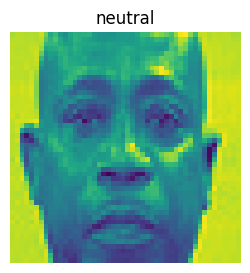

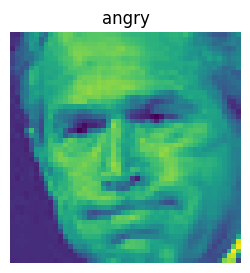

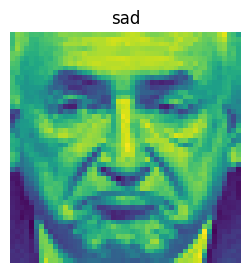

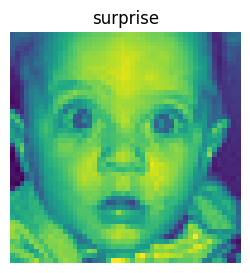

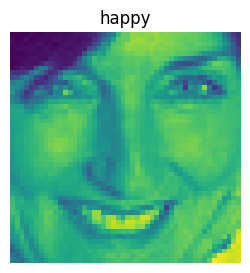

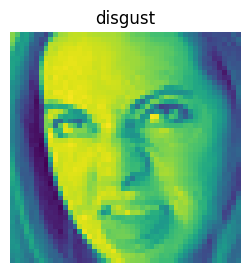

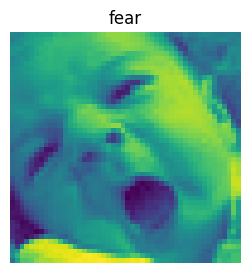

In [ ]:
plot_1_image('/content/train')

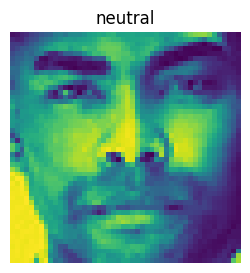

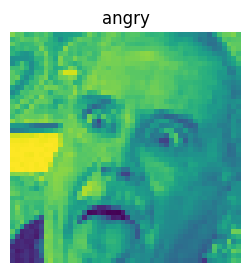

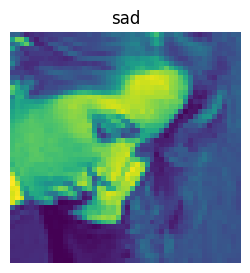

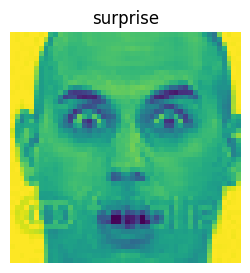

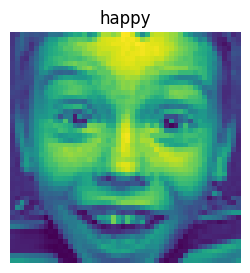

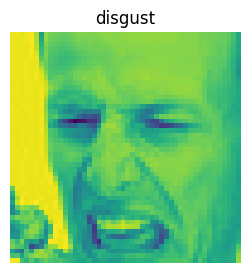

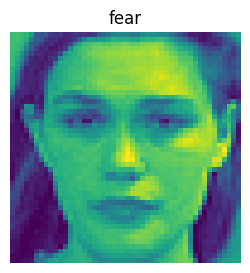

In [ ]:
plot_1_image('/content/test')

In [ ]:
#Plotting random images from a directory (of a specific emotion)

def plot_random_images(path, emotion, num_images=3):
  imgs = random.sample(os.listdir(os.path.join(path, emotion)), num_images)
  plt.figure(figsize=(10, 10))
  for i, img in enumerate(imgs):
    img = plt.imread(os.path.join(path, emotion, img))
    plt.subplot(1, num_images, i+1)
    plt.imshow(img)

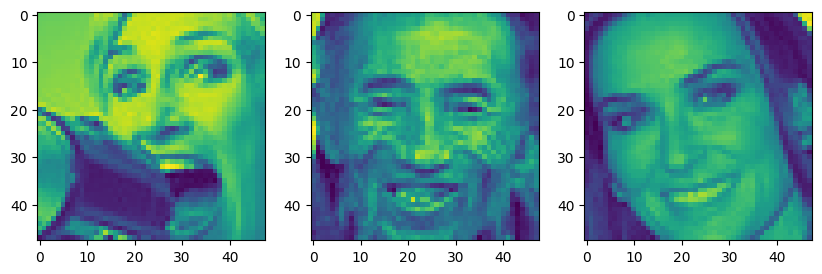

In [ ]:
plot_random_images('/content/train', 'happy')

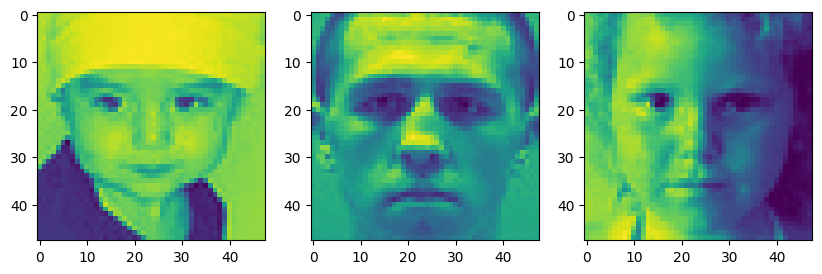

In [ ]:
plot_random_images('/content/train', 'neutral')

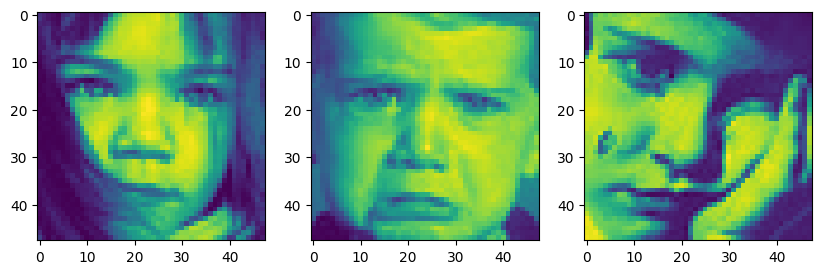

In [ ]:
plot_random_images('/content/test', 'sad')

In [ ]:
data_generator = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_dir = '/content/train'
test_dir = '/content/test'

In [ ]:
#Creating Train, Validation, Test sets for training, validation and testing

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#Defining labels for each set

train_labels = train_generator.class_indices
print(train_labels)

validation_labels = validation_generator.class_indices
print(validation_labels)

test_labels = test_generator.class_indices
print(test_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


# Model 1

In [ ]:
#Defining the model (CNN from scratch)

model = Sequential(name='CNN_From_Scratch')

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "CNN_From_Scratch"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 46, 46, 64)        640       
                                                                 
 batch_normalization (Batch  (None, 46, 46, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 23, 23, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 batch_normalization_1 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                                  

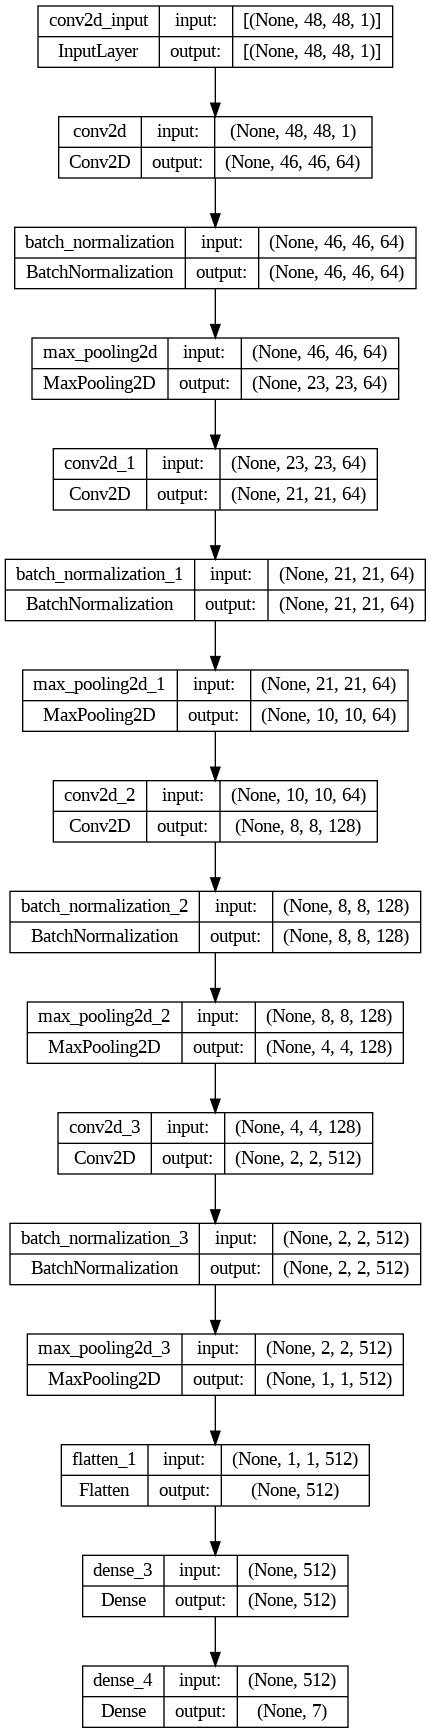

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

checkpoint_filepath = '/content/Facial_Emotion_Recognition/CNN_From_Scratch/Custom_CNN_model.keras'
modelcheckpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

csv_logger = CSVLogger('/content/Facial_Emotion_Recognition/CNN_From_Scratch/Custom_CNN_model.csv')

callbacks = [earlystopping, modelcheckpoint, csv_logger]

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20


UnimplementedError: Graph execution error:

Detected at node CNN_From_Scratch/conv2d/Relu defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-34-bb1fdd98e117>", line 1, in <cell line: 1>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1150, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 590, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/sequential.py", line 398, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 515, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/functional.py", line 672, in _run_internal_graph

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py", line 321, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/activations.py", line 306, in relu

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5395, in relu

Fused conv implementation does not support grouped convolutions for now.
	 [[{{node CNN_From_Scratch/conv2d/Relu}}]] [Op:__inference_train_function_5038]

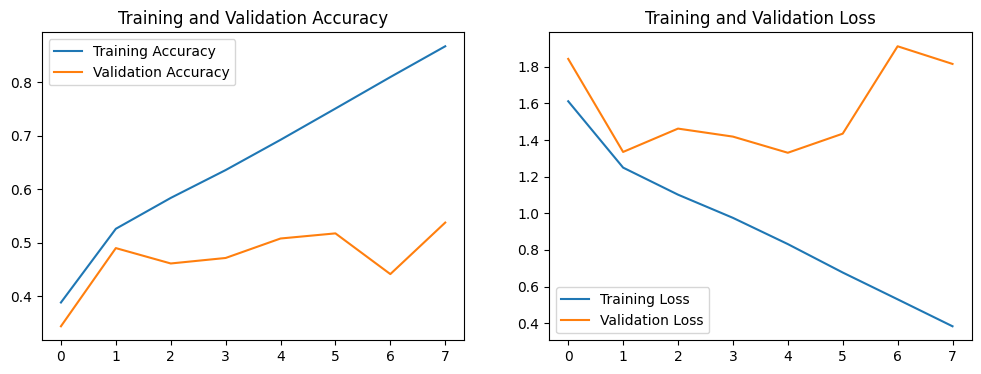

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))


plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')


plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

## Evaluating the model

In [ ]:
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)

113/113 [==============================] - 3s 22ms/step


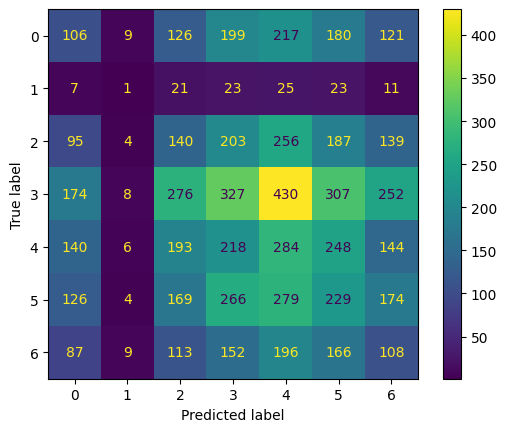

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_generator.classes, preds)

In [ ]:
precision = precision_score(test_generator.classes, preds, average='weighted')
recall = recall_score(test_generator.classes, preds, average='weighted')
f1_score = f1_score(test_generator.classes, preds, average='weighted')

print('F1 score is', f1_score)
print('Precision score is', precision)
print('Recall score is', recall)

F1 score is 0.16562309359703795
Precision score is 0.16887243448485567
Recall score is 0.16648091390359432


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, preds, target_names = list(test_generator.class_indices.keys())))

              precision    recall  f1-score   support

       angry       0.14      0.11      0.13       958
     disgust       0.02      0.01      0.01       111
        fear       0.13      0.14      0.14      1024
       happy       0.24      0.18      0.21      1774
     neutral       0.17      0.23      0.19      1233
         sad       0.17      0.18      0.18      1247
    surprise       0.11      0.13      0.12       831

    accuracy                           0.17      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.17      0.17      0.17      7178



In [ ]:
pickle.dump(model, open('/content/Facial_Emotion_Recognition/CNN_From_Scratch/Custom_CNN_model.pkl', 'wb'))

#Model 2 (CNN with augmentation)

In [ ]:
#Doing data augmentation

data_generator = ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 30,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True,
    fill_mode = 'nearest',
    validation_split = 0.2)



train_dir = '/content/train'
test_dir = '/content/test'

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='training')

validation_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(48,48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='validation')

test_generator = data_generator.flow_from_directory(
    test_dir,
    target_size = (48,48),
    color_mode = 'grayscale',
    batch_size = 64,
    class_mode = 'categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
#Defining labels for each set

train_labels = train_generator.class_indices
print(train_labels)

validation_labels = validation_generator.class_indices
print(validation_labels)

test_labels = test_generator.class_indices
print(test_labels)

{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}
{'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'neutral': 4, 'sad': 5, 'surprise': 6}


In [ ]:
#Defining the model (CNN from scratch)

model = Sequential(name='CNN_From_Scratch_with_Augmentation')

model.add(Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(512, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(7, activation='softmax'))

In [ ]:
model.summary()

Model: "CNN_From_Scratch_with_Augmentation"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 46, 46, 64)        640       
                                                                 
 batch_normalization_4 (Bat  (None, 46, 46, 64)        256       
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 21, 21, 64)        36928     
                                                                 
 batch_normalization_5 (Bat  (None, 21, 21, 64)        256       
 chNormalization)                                                
                                

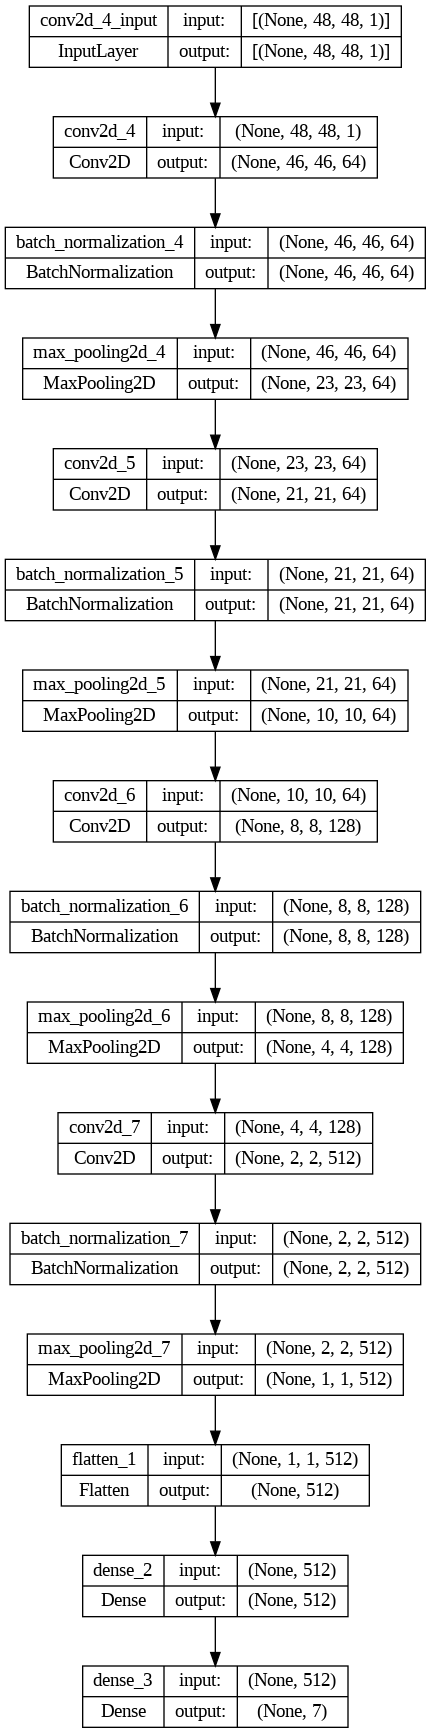

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3)

checkpoint_filepath = '/content/Facial_Emotion_Recognition/CNN_From_Scratch_With_Augmentation/Custom_CNN_model.keras'
modelcheckpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)

csv_logger = CSVLogger('/content/Facial_Emotion_Recognition/CNN_From_Scratch/Custom_CNN_model.csv')

callbacks = [earlystopping, modelcheckpoint, csv_logger]

In [ ]:
history = model.fit(train_generator, epochs=20, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/20
359/359 [==============================] - ETA: 0s - loss: 1.8812 - accuracy: 0.2601
Epoch 1: val_accuracy improved from -inf to 0.17314, saving model to /content/Facial_Emotion_Recognition/CNN_From_Scratch_With_Augmentation/Custom_CNN_model.keras
359/359 [==============================] - 26s 64ms/step - loss: 1.8812 - accuracy: 0.2601 - val_loss: 2.1664 - val_accuracy: 0.1731
Epoch 2/20
359/359 [==============================] - ETA: 0s - loss: 1.6702 - accuracy: 0.3321
Epoch 2: val_accuracy improved from 0.17314 to 0.29977, saving model to /content/Facial_Emotion_Recognition/CNN_From_Scratch_With_Augmentation/Custom_CNN_model.keras
359/359 [==============================] - 22s 60ms/step - loss: 1.6702 - accuracy: 0.3321 - val_loss: 1.7080 - val_accuracy: 0.2998
Epoch 3/20
359/359 [==============================] - ETA: 0s - loss: 1.5379 - accuracy: 0.3970
Epoch 3: val_accuracy improved from 0.29977 to 0.32729, saving model to /content/Facial_Emotion_Recognition/CNN_From_

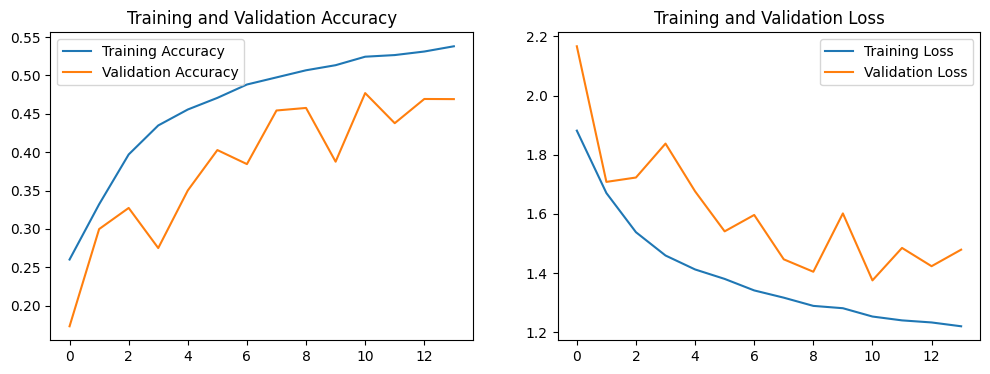

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)

113/113 [==============================] - 6s 50ms/step


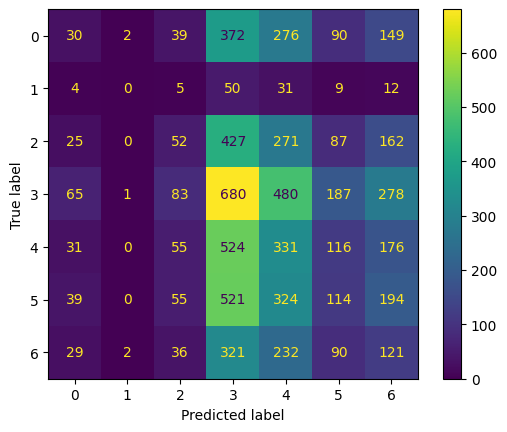

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_generator.classes, preds)

In [ ]:
precision = precision_score(test_generator.classes, preds, average='weighted')
recall = recall_score(test_generator.classes, preds, average='weighted')

print('Precision score is', precision)
print('Recall score is', recall)

Precision score is 0.16946997995598645
Recall score is 0.18500975202006129


In [ ]:
print(classification_report(test_generator.classes, preds, target_names = list(test_generator.class_indices.keys())))

              precision    recall  f1-score   support

       angry       0.13      0.03      0.05       958
     disgust       0.00      0.00      0.00       111
        fear       0.16      0.05      0.08      1024
       happy       0.23      0.38      0.29      1774
     neutral       0.17      0.27      0.21      1233
         sad       0.16      0.09      0.12      1247
    surprise       0.11      0.15      0.13       831

    accuracy                           0.19      7178
   macro avg       0.14      0.14      0.12      7178
weighted avg       0.17      0.19      0.16      7178



In [ ]:
pickle.dump(model, open('/content/Facial_Emotion_Recognition/CNN_From_Scratch_With_Augmentation/Custom_CNN_model.pkl', 'wb'))

#VGG16 Transfer Learning

In [ ]:
train_dir = '/content/train'
test_dir = '/content/test'

data_generator=ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2)

train_generator = data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='training')

validation_generator=data_generator.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical',
    subset='validation')

test_processing = ImageDataGenerator(rescale=1./255)

test_generator = test_processing.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    color_mode='rgb',
    batch_size=64,
    class_mode='categorical')

Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [ ]:
# Extract class labels for all instances in the training dataset
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(train_generator.classes)

# Calculate class weights to handle imbalances in the training data
# 'balanced' mode automatically adjusts weights inversely proportional to class frequencies
class_weights = compute_class_weight(
    class_weight='balanced',  # Strategy to balance classes
    classes=np.unique(classes),  # Unique class labels
    y=classes  # Class labels for each instance in the training dataset
)

# Create a dictionary mapping class indices to their calculated weights
class_weights_dict = dict(enumerate(class_weights))

# Output the class weights dictionary
print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.0266404434114071, 1: 9.401555464592715, 2: 1.0009587727708533, 3: 0.5684585684585685, 4: 0.826068191627104, 5: 0.8491570541259982, 6: 1.2933160650937552}


In [ ]:
train_generator.class_indices

{'angry': 0,
 'disgust': 1,
 'fear': 2,
 'happy': 3,
 'neutral': 4,
 'sad': 5,
 'surprise': 6}

In [ ]:
classes = 7

# Clear the previous TensorFlow sessionx
tf.keras.backend.clear_session()

In [ ]:
from tensorflow.keras.applications import VGG16

vgg16 = VGG16(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

58889256/58889256 [==============================] - 0s 0us/step


In [ ]:
vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
for layer in vgg16.layers[:-3]:
    layer.trainable = False

vgg16.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
model = Sequential(name='VGG_Transfer_Learning')

model.add(vgg16)
model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax', kernel_initializer='he_normal'))

model.summary()

Model: "VGG_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 1024)              25691136  
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)       

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False) , loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '/content/Facial_Emotion_Recognition/VGG16_Transfer_Learning/Custom_VGG16_model.keras'

modelcheckpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)

csv_logger = CSVLogger('/content/Facial_Emotion_Recognition/VGG16_Transfer_Learning/Custom_VGG16_model.csv')

callbacks = [modelcheckpoint, earlystopping,csv_logger]

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/10
254/359 [====================>.........] - ETA: 1:36 - loss: 1.7322 - accuracy: 0.3029

KeyboardInterrupt: 

In [ ]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(accuracy, label='Training Accuracy')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')

plt.show()

In [ ]:
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_generator.classes, preds)

In [ ]:
precision = precision_score(test_generator.classes, preds, average='weighted')
recall = recall_score(test_generator.classes, preds, average='weighted')
f1_score = f1_score(test_generator.classes, preds, average='weighted')

print('F1 score is', f1_score)
print('Precision score is', precision)
print('Recall score is', recall)

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_generator.classes, preds, target_names = list(test_generator.class_indices.keys())))

In [ ]:
pickle.dump(model, open('/content/Facial_Emotion_Recognition/VGG16_Transfer_Learning/Custom_VGG16_model.pkl', 'wb'))

#ResNet50 Transfer Learning

In [ ]:
from tensorflow.keras.applications import ResNet50V2

In [ ]:
resnet = ResNet50V2(weights='imagenet', input_shape=(224, 224, 3), include_top=False)

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
resnet.summary()

Model: "resnet50v2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 pool1_pad (ZeroPadding2D)   (None, 114, 114, 64)         0         ['conv1_conv[0][0]']          
                                                                                         

In [ ]:
len(resnet.layers)

190

In [ ]:
for layer in resnet.layers[:-50]:
    layer.trainable = False

In [ ]:
model = Sequential(name='ResNet50_Transfer_Learning')

model.add(resnet)

model.add(Flatten())
model.add(Dense(1024, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', kernel_initializer='he_normal'))
model.add(Dropout(0.5))
model.add(Dense(7, activation='softmax', kernel_initializer='he_normal'))

model.summary()

Model: "ResNet50_Transfer_Learning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 1024)              102761472 
                                                                 
 dropout (Dropout)           (None, 1024)              0         
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_2 (Dense)             (None, 7)  

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001, beta_1=0.9, beta_2=0.999, amsgrad=False),
    loss='categorical_crossentropy',
    metrics=['accuracy'])

In [ ]:
checkpoint_filepath = '/content/Facial_Emotion_Recognition/ResNet50_Transfer_Learning/Custom_ResNet50_model.keras'

modelcheckpoint = ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True, verbose=1)
earlystopping = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, patience = 3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=6, verbose=1, min_delta=0.0001)

csv_logger = CSVLogger('/content/Facial_Emotion_Recognition/ResNet50_Transfer_Learning/Custom_ResNet50_model.csv')

callbacks = [modelcheckpoint, earlystopping, reduce_lr]

In [ ]:
history = model.fit(train_generator, epochs=10, validation_data=validation_generator, callbacks=callbacks)

Epoch 1/10
359/359 [==============================] - ETA: 0s - loss: 1.8167 - accuracy: 0.3565
Epoch 1: val_loss improved from inf to 1.38264, saving model to /content/Facial_Emotion_Recognition/ResNet50_Transfer_Learning/Custom_ResNet50_model.keras
359/359 [==============================] - 431s 1s/step - loss: 1.8167 - accuracy: 0.3565 - val_loss: 1.3826 - val_accuracy: 0.4760 - lr: 1.0000e-04
Epoch 2/10
359/359 [==============================] - ETA: 0s - loss: 1.3726 - accuracy: 0.4806
Epoch 2: val_loss improved from 1.38264 to 1.25529, saving model to /content/Facial_Emotion_Recognition/ResNet50_Transfer_Learning/Custom_ResNet50_model.keras
359/359 [==============================] - 396s 1s/step - loss: 1.3726 - accuracy: 0.4806 - val_loss: 1.2553 - val_accuracy: 0.5262 - lr: 1.0000e-04
Epoch 3/10
359/359 [==============================] - ETA: 0s - loss: 1.2473 - accuracy: 0.5320
Epoch 3: val_loss improved from 1.25529 to 1.17920, saving model to /content/Facial_Emotion_Recognit

In [ ]:
preds = model.predict(test_generator)
preds = np.argmax(preds, axis=1)

113/113 [==============================] - 23s 197ms/step


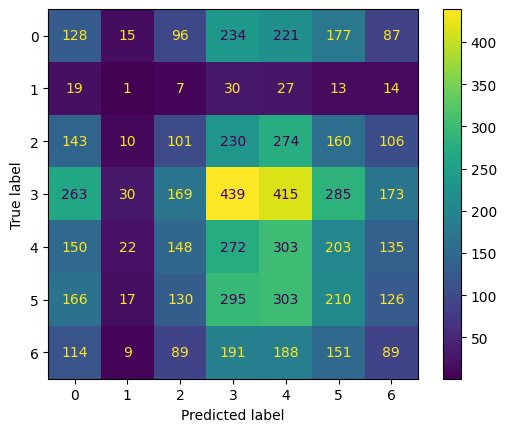

In [ ]:
ConfusionMatrixDisplay.from_predictions(test_generator.classes, preds)

In [ ]:
precision = precision_score(test_generator.classes, preds, average='weighted')
recall = recall_score(test_generator.classes, preds, average='weighted')
f1_score = f1_score(test_generator.classes, preds, average='weighted')

print('F1 score is', f1_score)
print('Precision score is', precision)
print('Recall score is', recall)

F1 score is 0.17485804099640964
Precision score is 0.17576913644103379
Recall score is 0.1770688213987183


In [ ]:
print(classification_report(test_generator.classes, preds, target_names = list(test_generator.class_indices.keys())))

              precision    recall  f1-score   support

       angry       0.13      0.13      0.13       958
     disgust       0.01      0.01      0.01       111
        fear       0.14      0.10      0.11      1024
       happy       0.26      0.25      0.25      1774
     neutral       0.18      0.25      0.20      1233
         sad       0.18      0.17      0.17      1247
    surprise       0.12      0.11      0.11       831

    accuracy                           0.18      7178
   macro avg       0.14      0.14      0.14      7178
weighted avg       0.18      0.18      0.17      7178



In [ ]:
pickle.dump(model, open('/content/Facial_Emotion_Recognition/ResNet50_Transfer_Learning/Custom_ResNet50_model.pkl', 'wb'))

In [ ]:
# prompt: how to check the version of pickle

import pickle
print(pickle.format_version)
